<a href="https://colab.research.google.com/github/rkdune/roadtojepa/blob/main/two_encoder_road_2_jepa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install allensdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.0/336.0 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

In [2]:
# Download the data
cache = BrainObservatoryCache(manifest_file='boc_manifest.json')

expt_id = 649409874
data_set = cache.get_ophys_experiment_data(expt_id)
print(f"Using experiment ID: {expt_id}")

# Get the fluorescence traces
dff_traces = data_set.get_dff_traces()
neuron_traces = dff_traces[1]

# Normalize the data
neuron_traces = (neuron_traces - np.min(neuron_traces)) / (np.max(neuron_traces) - np.min(neuron_traces))

# Reshape the data for the autoencoder
X = neuron_traces.T
X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, channels, time_steps)

print(f"Data shape: {X.shape}")

2024-07-09 22:52:20,501 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/650079447
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/650079447


Using experiment ID: 649409874
Data shape: (118996, 1, 26)


In [3]:
# Split the data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train, X_train)
test_dataset = TensorDataset(X_test, X_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [56]:
class DenoisingEncoderModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, momentum=0.998):
        super(DenoisingEncoderModel, self).__init__()

        # Encoder for noisy data (Enc(x))
        self.encoder_x = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        # Encoder for original data (Enc(y))
        self.encoder_y = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        # Initialize Enc(y) with Enc(x) weights
        self.encoder_y.load_state_dict(self.encoder_x.state_dict())

        # Disable gradient computation for Enc(y)
        for param in self.encoder_y.parameters():
            param.requires_grad = False

        self.momentum = momentum
        self.mse_loss = nn.MSELoss()

    def forward(self, x, y):
        # Encode noisy data
        encoded_x = self.encoder_x(x)

        # Encode original data (no gradients)
        with torch.no_grad():
            encoded_y = self.encoder_y(y)

        # Calculate MSE loss
        loss = self.mse_loss(encoded_x, encoded_y)

        return encoded_x, encoded_y, loss

    def update_moving_average(self):
        # Update Enc(y) as a moving average of Enc(x)
        with torch.no_grad():
            for param_x, param_y in zip(self.encoder_x.parameters(), self.encoder_y.parameters()):
                param_y.data = self.momentum * param_y.data + (1.0 - self.momentum) * param_x.data

In [47]:
def add_noise(data, noise_level):
    return data + noise_level * torch.randn_like(data)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Example usage
input_dim = X.shape[2]  # This will be the number of time steps in your data
hidden_dim = max(64, input_dim // 2)  # Adjust as needed
output_dim = max(32, hidden_dim // 2) # Adjust as needed
num_epochs = 1
learning_rate = 0.001
noise_level = 0.9
train_losses = []
test_losses = []

model = DenoisingEncoderModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# In your training loop:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch_x, _ in train_loader:
        optimizer.zero_grad()
        noisy_x = add_noise(batch_x, noise_level)  # Add noise to input for Enc(x)
        _, _, loss = model(noisy_x, batch_x)  # Use noisy data for input and clean data for target
        loss.backward()
        optimizer.step()
        model.update_moving_average()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for batch_x, _ in test_loader:
            noisy_x = add_noise(batch_x, noise_level)  # Add noise to test data as well
            _, _, loss = model(noisy_x, batch_x)  # Use noisy data for input and clean data for target
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.9f}, Test Loss: {avg_test_loss:.9f}")

cuda
Epoch [1/1], Train Loss: 0.000500672, Test Loss: 0.000000635


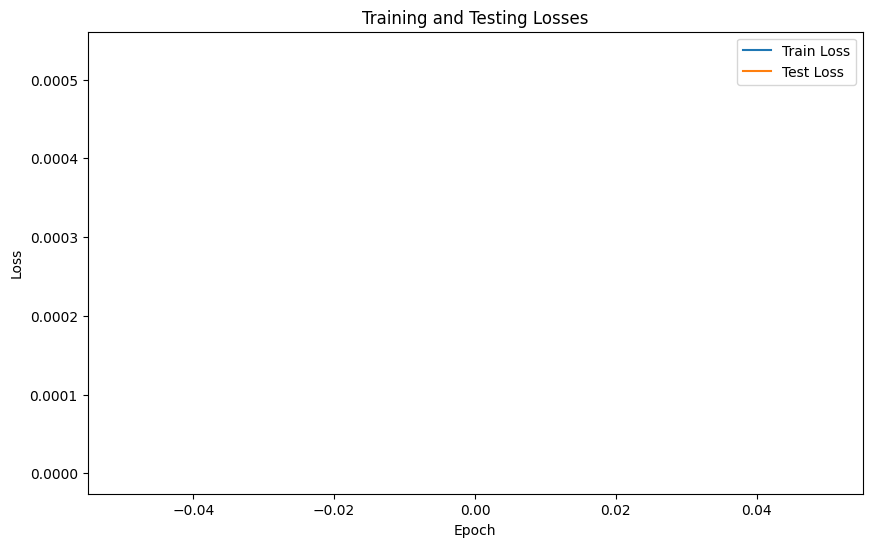

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

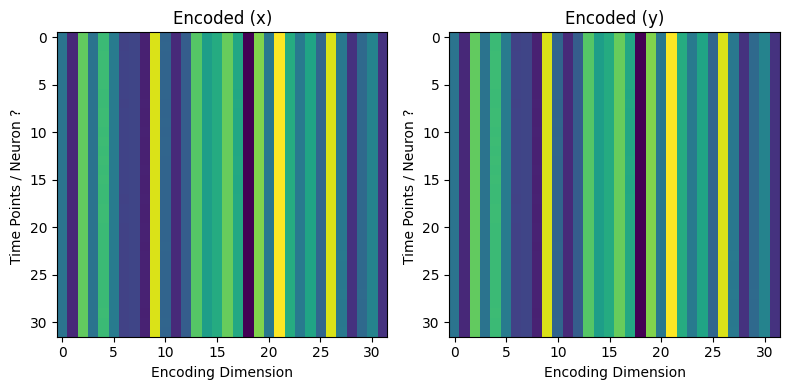

In [55]:
sample_batch, _ = next(iter(test_loader))

model.eval()
with torch.no_grad():
    encoded_x, encoded_y, _ = model(sample_batch, sample_batch)

# Convert to numpy and reshape
encoded_x = encoded_x.squeeze().numpy()  # Remove the channel dimension
encoded_y = encoded_y.squeeze().numpy()

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(encoded_x, aspect='auto', cmap='viridis')
plt.title('Encoded (x)')
plt.xlabel('Encoding Dimension')
plt.ylabel('Time Points / Neuron ? ')

plt.subplot(1, 2, 2)
plt.imshow(encoded_y, aspect='auto', cmap='viridis')
plt.title('Encoded (y)')
plt.xlabel('Encoding Dimension')
plt.ylabel('Time Points / Neuron ? ')

plt.tight_layout()
plt.show()